# Setup

In [1]:
DATA_VERSION = "2025-06-16"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

# Do not train nor test on documents from cantons that have known data quality issues.
EXCLUDE_POLITICAL_BODIES = {
    "bl",
    "ge",
    "ne",
    "sz",
    "vd",
    "vs",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # These are labels after class merging.
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
    "SURVEY",
}

CV_FOLDS = 5
# This fraction only applies to manually labelled OpenParlData documents. Many more documents make it
# into the training set, e.g. all Fedlex documents.
TEST_SIZE = 0.15
RANDOM_STATE = 271828

RUN_HYPEROPTIMIZATION = False
HYPERPARAMETERS = {
    "classifier": {
        "type": "SVC",
        "C": 1.0,
        "class_weight": None,
        "gamma": "scale",
        "kernel": {"type": "rbf"},
    },
    "pca_n_components": 100,
}

assert RUN_HYPEROPTIMIZATION ^ bool(HYPERPARAMETERS)

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import sys
from typing import Any

import dotenv
import hyperopt
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
from hyperopt import pyll

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
import demokratis_ml.models.document_types.model
import demokratis_ml.models.document_types.preprocessing
from research.document_types import document_title_rule_model, training_split
from research.lib import data_access, plotting, utils

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [4]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s %(name)s: %(message)s")

In [5]:
dotenv.load_dotenv()

True

In [6]:
if os.environ.get("MLFLOW_TRACKING_USERNAME") and os.environ.get("MLFLOW_TRACKING_PASSWORD"):
    mlflow.set_tracking_uri("https://mlflow.ml1.demokratis.ch/")
else:
    logging.warning("MLflow credentials not found, will track locally.")
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

mlflow.set_experiment("VM_document_type_classifier")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("run_hyperoptimization", RUN_HYPEROPTIMIZATION)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("exclude_political_bodies", sorted(EXCLUDE_POLITICAL_BODIES))
mlflow.log_param("merge_classes", demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES)
;

Starting run: loud-cub-101


''

# Input data preparation

## Get all dataframes

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-06-16.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-06-16.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-06-16.parquet already exists locally.


In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE, only_languages=LANGUAGES, starting_year=FROM_YEAR
)
df_docs

,document_id,document_uuid,consultation_id,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,...,organisation_name,political_body,latest_stored_file_id,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1,1CAJoURQMxKeqCdQ4jLniS,1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,...,Bundesamt für Zoll und Grenzsicherheit,ch,7780,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
3,4,1CAJoURQMxKeqCdQ4vhCQx,1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,...,Bundesamt für Zoll und Grenzsicherheit,ch,7783,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/4/1CM3wfhvda7QqrdPBrFGXj.pdf,application/pdf,d47bb05bc7f135a0b850702336ecca328f7dafce
6,7,1CAJoURQMxKeqCdQ564eYH,1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,...,Bundesamt für Zoll und Grenzsicherheit,ch,7786,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb
9,10,1CAJoURQbi5gxw7Wp5N5rT,1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,...,Bundesamt für Zoll und Grenzsicherheit,ch,7789,fedlex,manual,fedlex,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
12,13,1CAJoURQbi5gxw7WpL8ns1,1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,...,Bundesamt für Zoll und Grenzsicherheit,ch,7792,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53655,55620,1CQJjbwhpdvhrLFkLB6RAF,5165,x9z8dd39,2025-06-18,NaT,"Revision der Kantonsverfassung (KV), des Geric...",,https://www.ai.ch/politik/standeskommission/ka...,https://www.demokratis.ch/vernehmlassung/x9z8dd39,...,Standeskommission Appenzell Innerrhoden,ai,<NA>,openparldata,openparldata,NaN,AI 013.25-27.73.5-1305837 1-11 \nBotschaft \n...,None,None,None
53656,55621,1CQJjbwhpdvhrLFkLGeRih,5165,x9z8dd39,2025-06-18,NaT,"Revision der Kantonsverfassung (KV), des Geric...",,https://www.ai.ch/politik/standeskommission/ka...,https://www.demokratis.ch/vernehmlassung/x9z8dd39,...,Standeskommission Appenzell Innerrhoden,ai,<NA>,openparldata,openparldata,NaN,\nSynopse \n \nLandsgemeindebeschluss über di...,None,None,None
53657,55622,1CQJjbwhpdvhrLFkLN5tPh,5165,x9z8dd39,2025-06-18,NaT,"Revision der Kantonsverfassung (KV), des Geric...",,https://www.ai.ch/politik/standeskommission/ka...,https://www.demokratis.ch/vernehmlassung/x9z8dd39,...,Standeskommission Appenzell Innerrhoden,ai,<NA>,openparldata,openparldata,NaN,Kanton Appenzell Innerrhoden E 173.000\nVerne...,None,None,None
53658,55623,1CQJjbwhpdvhrLFkLSiWER,5165,

In [9]:
df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,,contains_table_on_first_page,count_pages,count_tables,count_pages_containing_tables,count_images,count_pages_containing_images,average_page_aspect_ratio
document_id,stored_file_hash,,,,,,,
1,b8816738ad84d806e55723a313613097bed2752f,False,26,0.0,0.0,0.0,0.0,0.704898
4,d47bb05bc7f135a0b850702336ecca328f7dafce,False,6,0.0,0.0,1.0,1.0,0.707098
7,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,False,2,0.0,0.0,1.0,1.0,0.707098
10,b631111878a9eea5ae89bdc7ce85d86c609856a3,False,15,0.0,0.0,13.0,6.0,0.707098
13,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,False,2,0.0,0.0,1.0,1.0,0.707098
...,...,...,...,...,...,...,...,...
55536,0d601c038b527fc3714eda0f20004d1ccd31064b,False,2,0.0,0.0,2.0,1.0,0.706956
55537,387d08ff629e9c3c5c10eb10eec087818b9130fa,False,3,0.0,0.0,1.0,1.0,0.707071
55538,f7d4f8dae1b33b2972d7698f3fef9a023bc688b4,False,1,0.0,0.0,1.0,1.0,0.707098


In [10]:
df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_id,
1,"[0.01030252780765295, -0.014312159270048141, -..."
4,"[0.011395552195608616, 0.0014780974015593529, ..."
7,"[-0.005767590366303921, 0.002646328415721655, ..."
10,"[0.019797369837760925, -0.00907826703041792, -..."
13,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
55536,"[0.021826179698109627, -0.0004514033498708159,..."
55537,"[-0.01725662872195244, -0.01927938312292099, -..."
55538,"[-0.01678720861673355, -0.01213048305362463, -..."


In [11]:
embedding_dimension = df_embeddings["embedding"].iloc[0].shape[0]
print("Embedding dimension:", embedding_dimension)

Embedding dimension: 3072


## Preprocess

In [12]:
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    df_docs,
    df_extra_features=df_features,
    df_embeddings=df_embeddings,
)

INFO document_types.preprocessing: Dropping 1271 documents (5.4%) with empty texts
/Users/vita/Code/demokratis/demokratis-ml/demokratis_ml/models/document_types/features.py:56: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["consultation_start_timestamp"] = df["consultation_start_date"].view("int64") // 10**9
INFO document_types.features: 3395 rows (15.2%) were lost due to missing features. Remaining rows: 18971. 15 columns were added.
INFO document_types.features: Lost documents by political_body/year:
year            2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024  2025   Total
political_body                                                                                                                          
ag                 0     0     0     0     0    53    17    21     6     0    41     3    59    58    18    24     5     3 

In [13]:
print(
    "Excluding documents from these political bodies from the data:",
    df_input[df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]["political_body"].astype(str).value_counts(),
    sep="\n",
)
df_input = df_input[~df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]

Excluding documents from these political bodies from the data:
political_body
sz    345
vs     12
bl      9
Name: count, dtype: int64


## Split

In [14]:
df_input_train, (df_input_test_1, df_input_test_2) = training_split.train_test_split(
    df_input,
    random_state=RANDOM_STATE,
    test_sizes=(TEST_SIZE, TEST_SIZE),
    include_rule_labels_in_training=INCLUDE_RULE_LABELS_IN_TRAINING,
    stratify_by_canton=False,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.29% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.06% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.13% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.14% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.03% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_ru

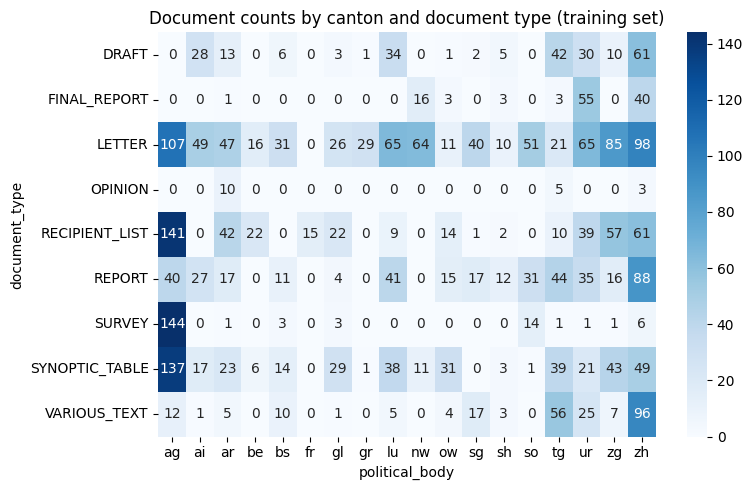

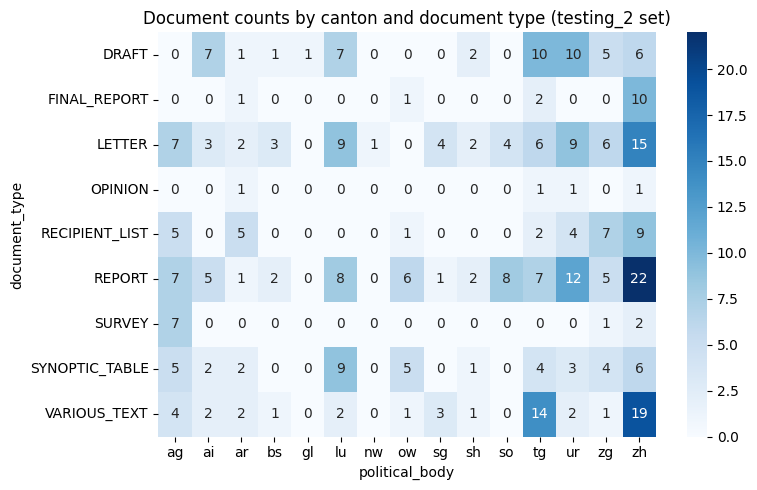

In [15]:
def plot_documents_per_canton(df: pd.DataFrame, set_name: str) -> None:
    df = df[df["political_body"] != "ch"]
    count_matrix = pd.crosstab(df["document_type"], df["political_body"])
    count_matrix = count_matrix.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(count_matrix, annot=True, fmt="g", cmap="Blues")
    plt.title(f"Document counts by canton and document type ({set_name} set)")
    plt.tight_layout()
    plt.show()


plot_documents_per_canton(df_input_train, "training")
plot_documents_per_canton(df_input_test_2, "testing_2")

In [16]:
display(df_input_train["document_type_label_source"].value_counts(dropna=False))
display(df_input_train["document_type"].value_counts(dropna=False))

document_type_label_source
fedlex    12232
manual     1683
rule       1219
Name: count, dtype: int64

document_type
LETTER            3265
DRAFT             3057
REPORT            2493
RECIPIENT_LIST    2162
FINAL_REPORT      1839
OPINION            895
VARIOUS_TEXT       647
SYNOPTIC_TABLE     579
SURVEY             197
DECISION             0
LINK                 0
PRESS_RELEASE        0
RESPONSE_FORM        0
Name: count, dtype: int64

In [17]:
display(df_input_test_2["document_type_label_source"].value_counts(dropna=False))
display(df_input_test_2["document_type"].value_counts(dropna=False))

document_type_label_source
manual    361
rule        0
fedlex      0
Name: count, dtype: int64

document_type
REPORT            86
LETTER            71
VARIOUS_TEXT      52
DRAFT             50
SYNOPTIC_TABLE    41
RECIPIENT_LIST    33
FINAL_REPORT      14
SURVEY            10
OPINION            4
DECISION           0
LINK               0
PRESS_RELEASE      0
RESPONSE_FORM      0
Name: count, dtype: int64

In [18]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_1_samples_count", len(df_input_test_1))
mlflow.log_param("test_2_samples_count", len(df_input_test_2))

361

# Data exploration

## Data representation

In [19]:
print("df_input_train labels:")
df_input_train.groupby("document_type_label_source", observed=False)["document_type"].value_counts(dropna=False)

df_input_train labels:


document_type_label_source  document_type 
rule                        LETTER             485
                            RECIPIENT_LIST     278
                            SYNOPTIC_TABLE     271
                            SURVEY             129
                            FINAL_REPORT        56
                            DECISION             0
                            DRAFT                0
                            LINK                 0
                            OPINION              0
                            PRESS_RELEASE        0
                            REPORT               0
                            RESPONSE_FORM        0
                            VARIOUS_TEXT         0
fedlex                      DRAFT             2821
                            LETTER            2450
                            REPORT            2095
                            RECIPIENT_LIST    1727
                            FINAL_REPORT      1718
                            OPINION    

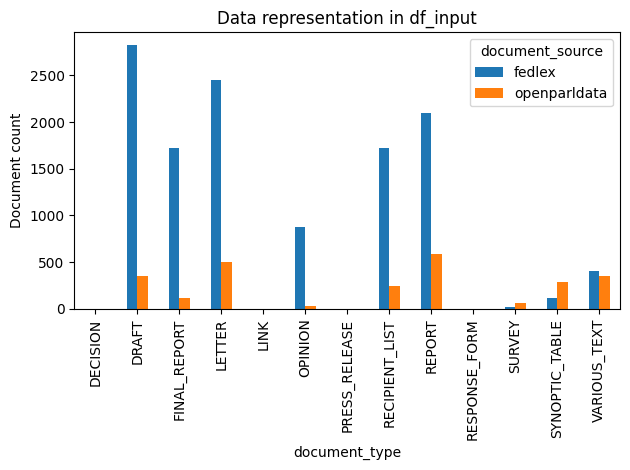

document_source,fedlex,openparldata
document_type,,
DECISION,0,0
DRAFT,2821,356
FINAL_REPORT,1718,112
LETTER,2450,498
LINK,0,0
OPINION,877,27
PRESS_RELEASE,0,0
RECIPIENT_LIST,1727,241
REPORT,2095,590


In [20]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
    )
)
display(repr_table)

## Extra features

In [21]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
DRAFT,0.001063,0.000000
FINAL_REPORT,0.002910,0.035714
LETTER,0.985306,0.995984
OPINION,0.751425,0.666667
RECIPIENT_LIST,0.000000,0.000000
REPORT,0.013365,0.049153
SURVEY,0.000000,0.046154
SYNOPTIC_TABLE,0.000000,0.000000
VARIOUS_TEXT,0.014815,0.011527


### Keyword-like features

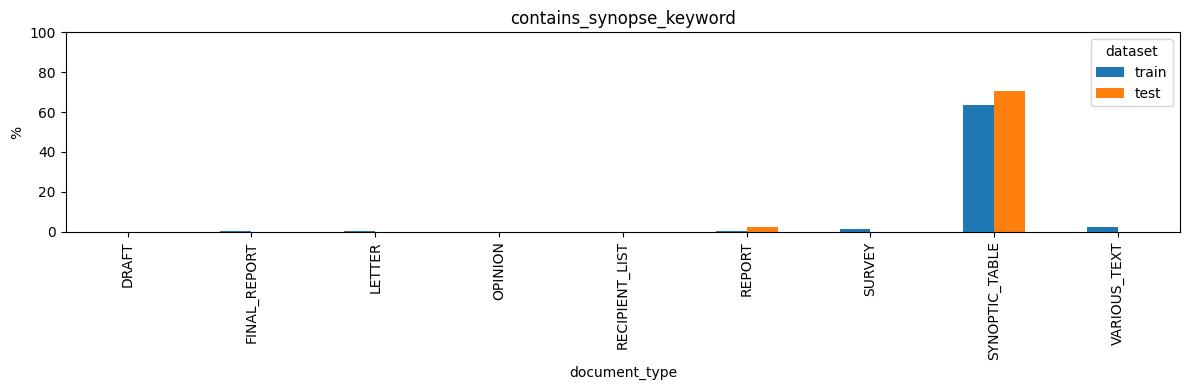

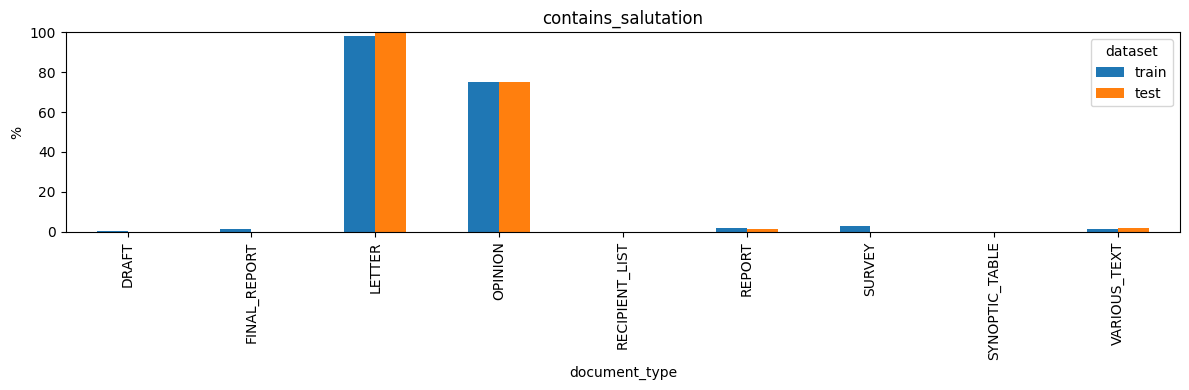

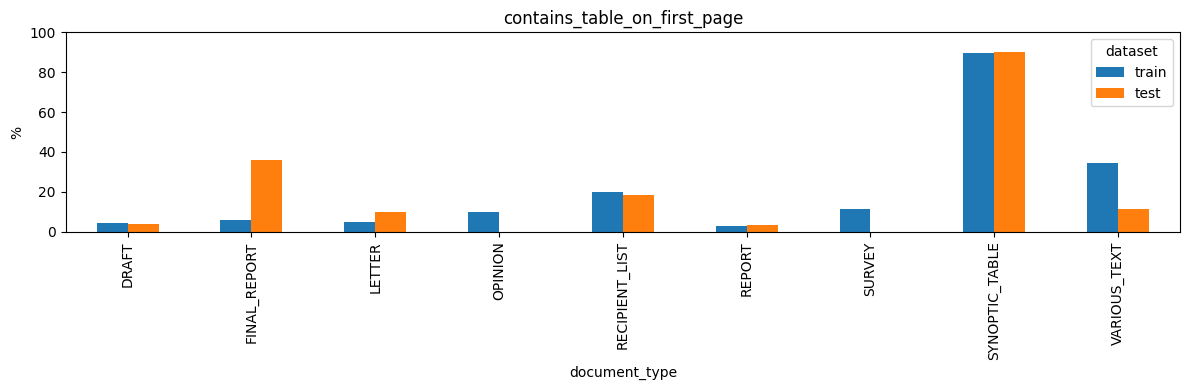

In [22]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_salutation")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_table_on_first_page")

In [23]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
    )
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

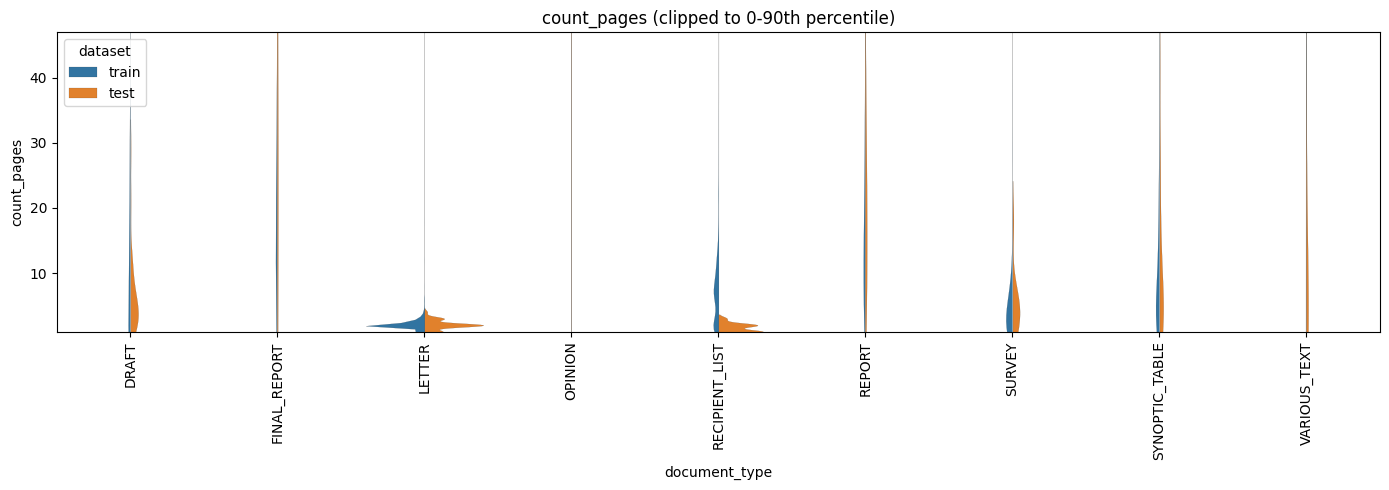

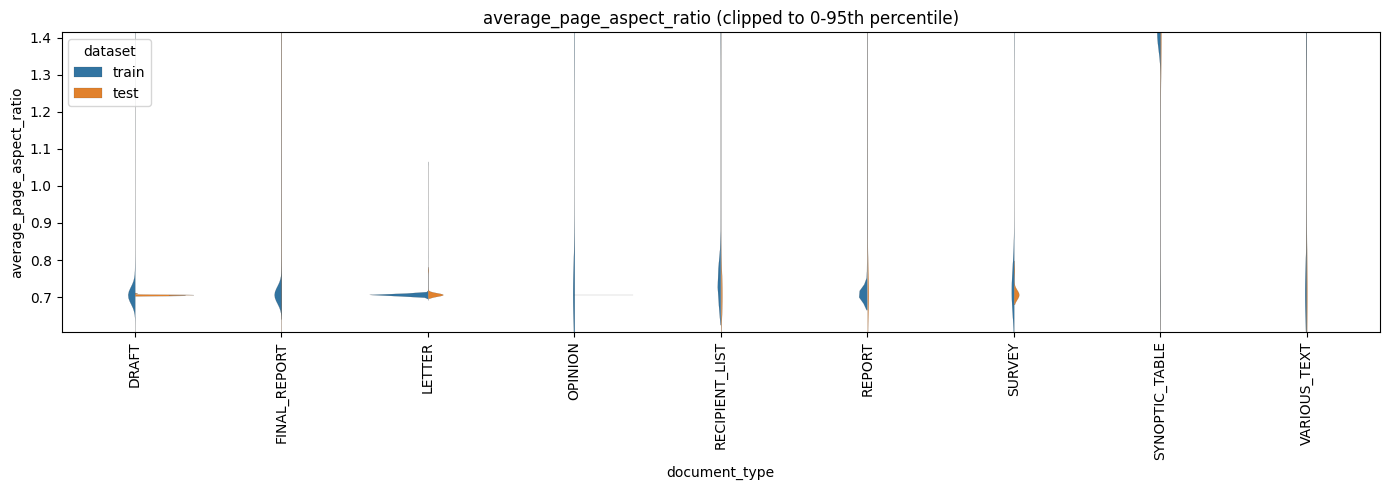

In [24]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "average_page_aspect_ratio", clip_y=(0, 95)
)

In [25]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                    std            
dataset               test       train       test       train
document_type                                                
DRAFT             5.940000   13.871770   5.096658   45.537108
FINAL_REPORT     34.500000   27.007069  40.778482   43.950975
LETTER            2.070423    2.148545   0.703541    1.389844
OPINION         107.250000  358.615642  74.397021  701.102602
RECIPIENT_LIST    1.606061    7.163737   0.658568    5.416397
REPORT           23.941860   24.816687  23.318942   30.461019
SURVEY            5.300000    4.700508   4.900113    7.437951
SYNOPTIC_TABLE   10.439024   10.880829  10.568937   14.268118
VARIOUS_TEXT     12.365385   21.326121  24.568455  155.034662

In [26]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.706105  0.729058  0.001284  0.112101
FINAL_REPORT    1.023735  0.725695  0.326251  0.099439
LETTER          0.708928  0.707762  0.010943  0.014203
OPINION         0.706997  0.818134  0.000000  0.244001
RECIPIENT_LIST  0.728473  0.769434  0.123296  0.178644
REPORT          0.764294  0.723085  0.151349  0.085374
SURVEY          0.713610  0.765981  0.020772  0.171653
SYNOPTIC_TABLE  1.348214  1.371071  0.193800  0.163570
VARIOUS_TEXT    0.774937  0.875918  0.208775  0.300606

### Tables

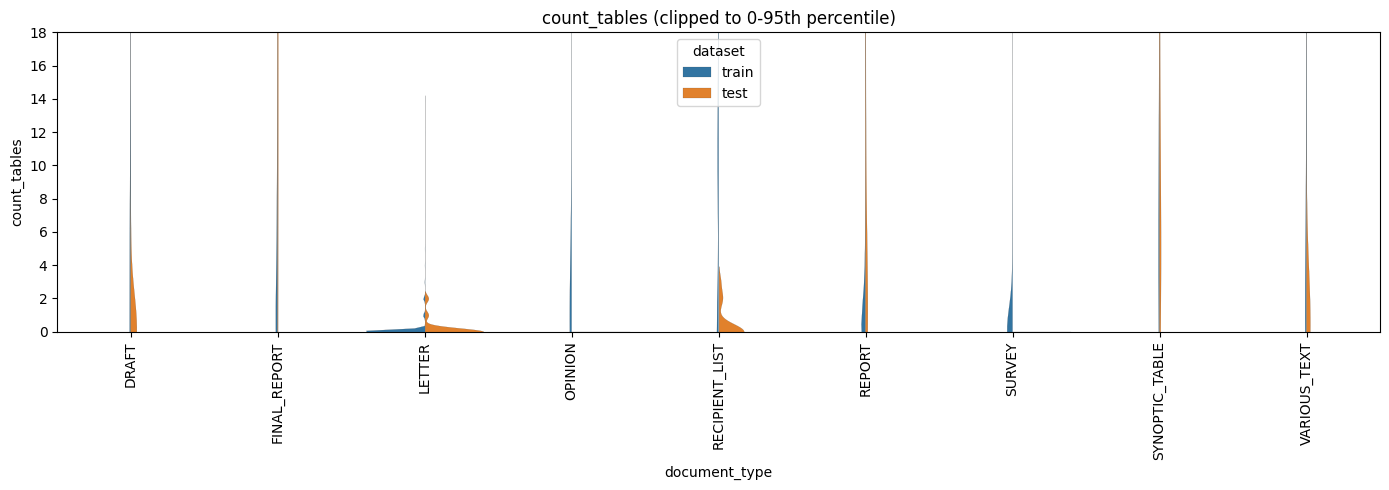

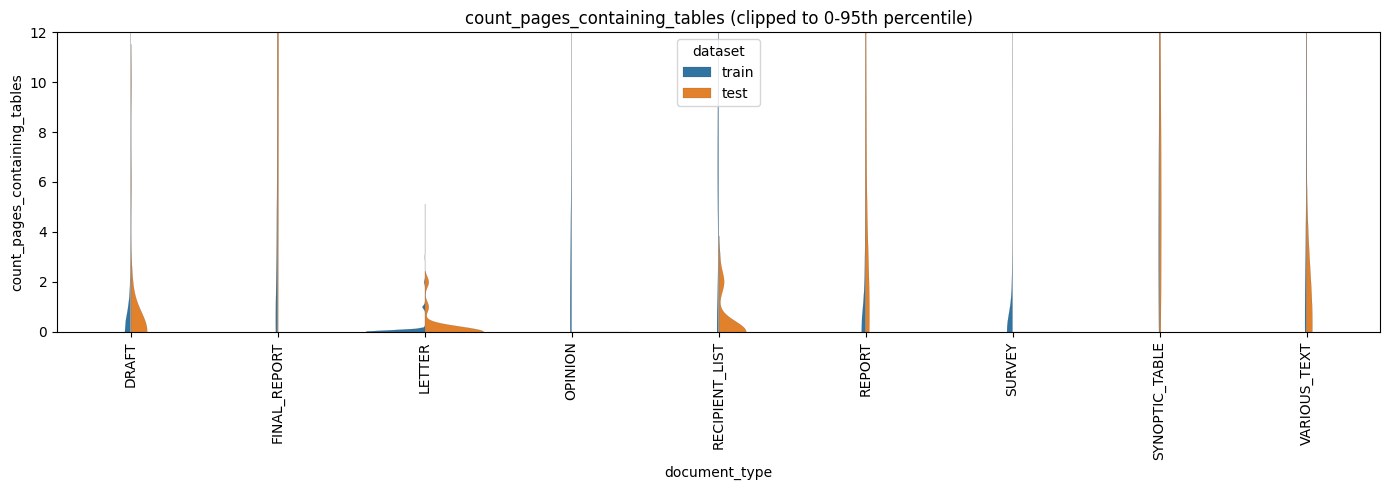

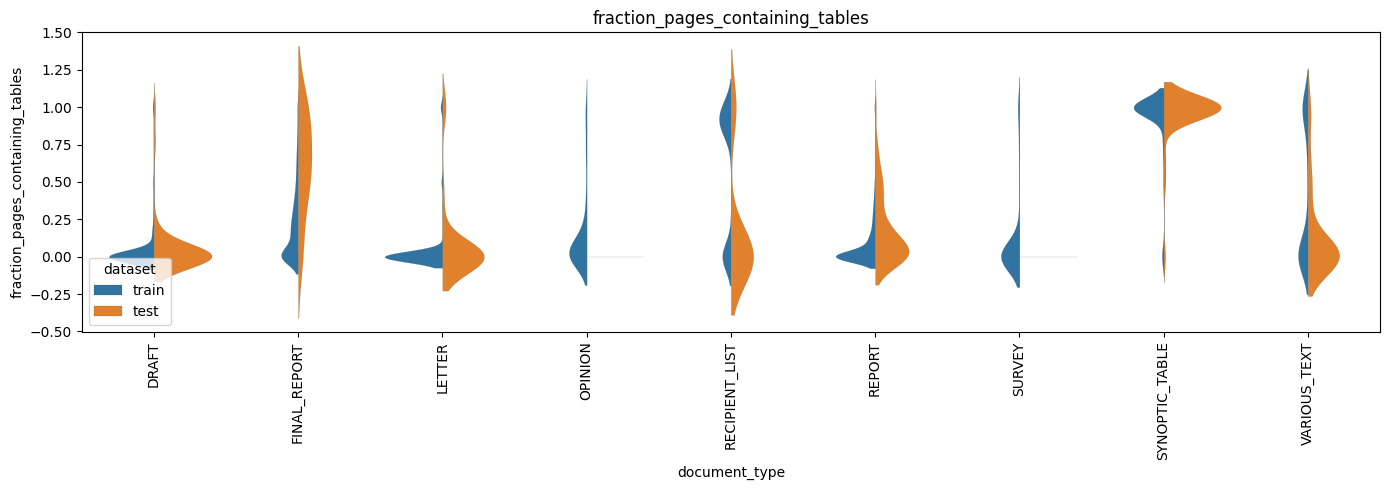

In [27]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_tables")

### Images

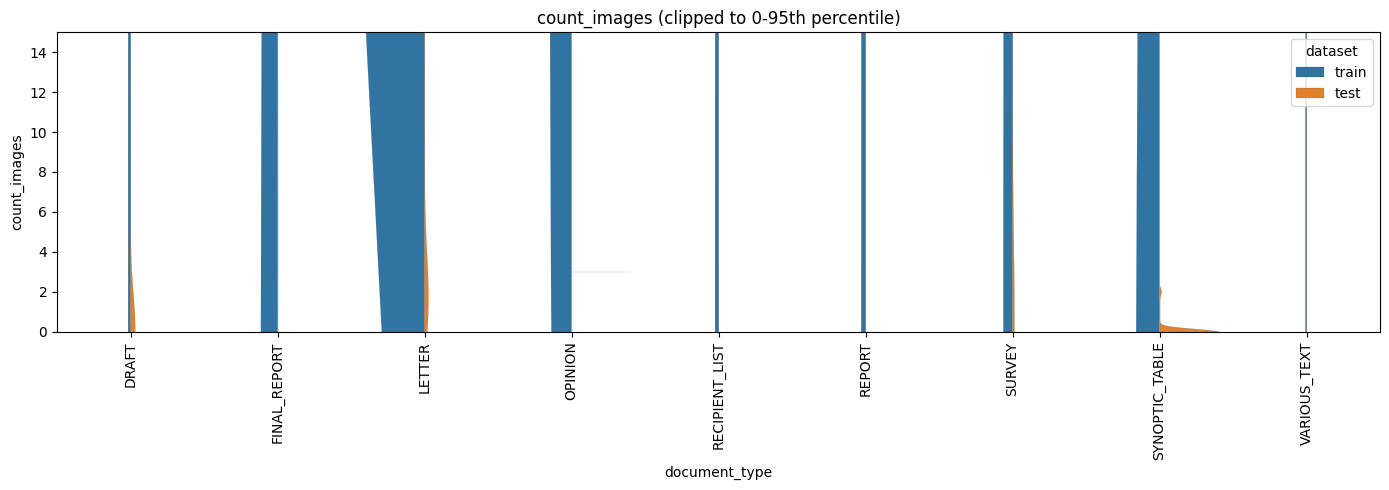

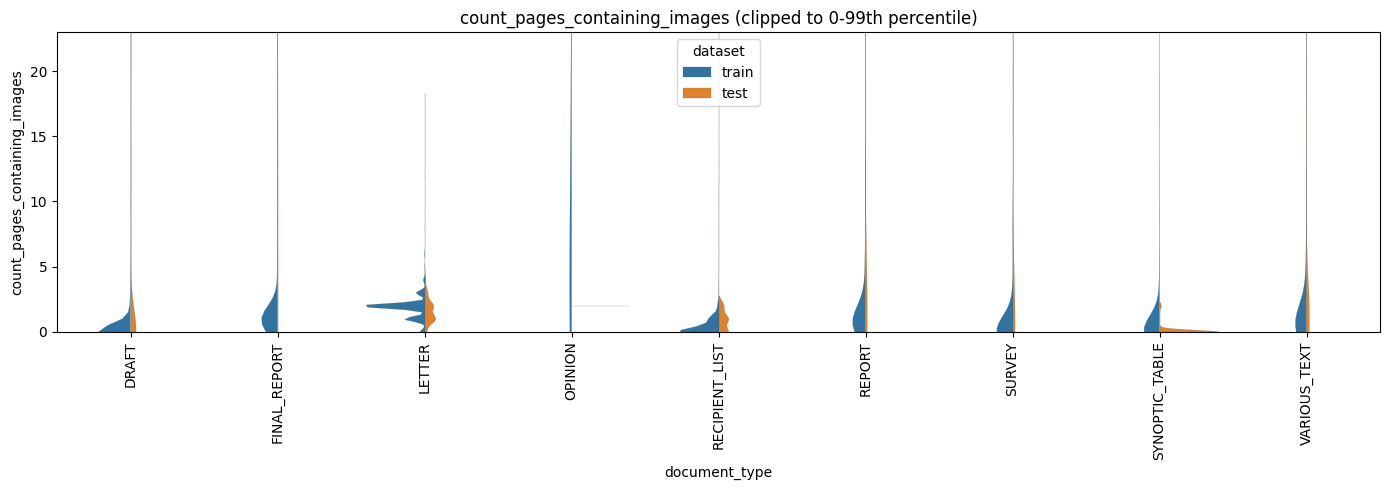

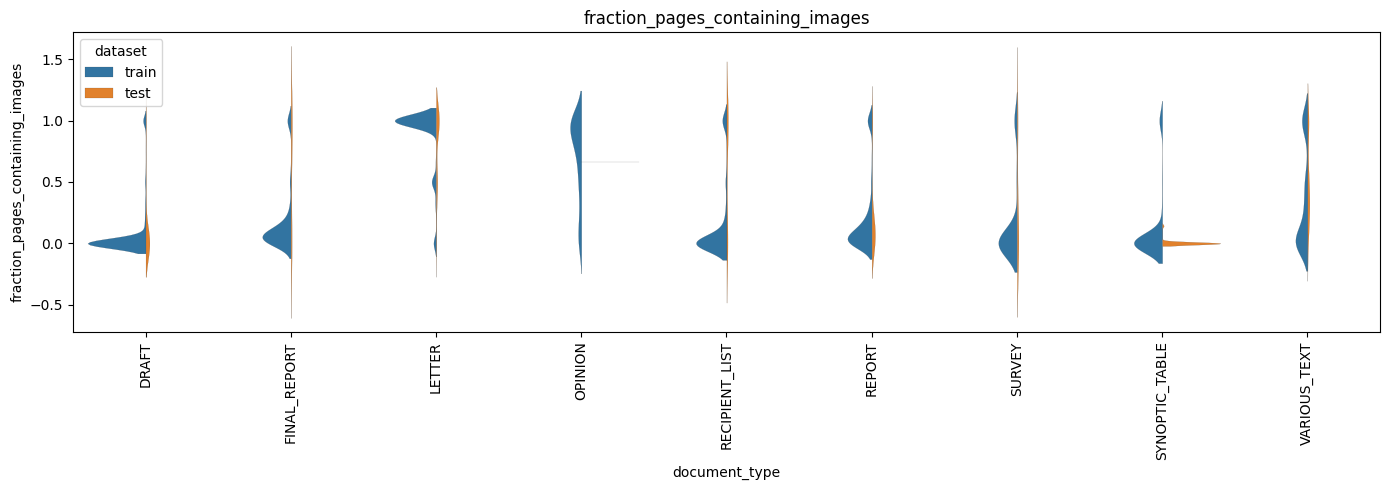

In [28]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_images")

### Time features

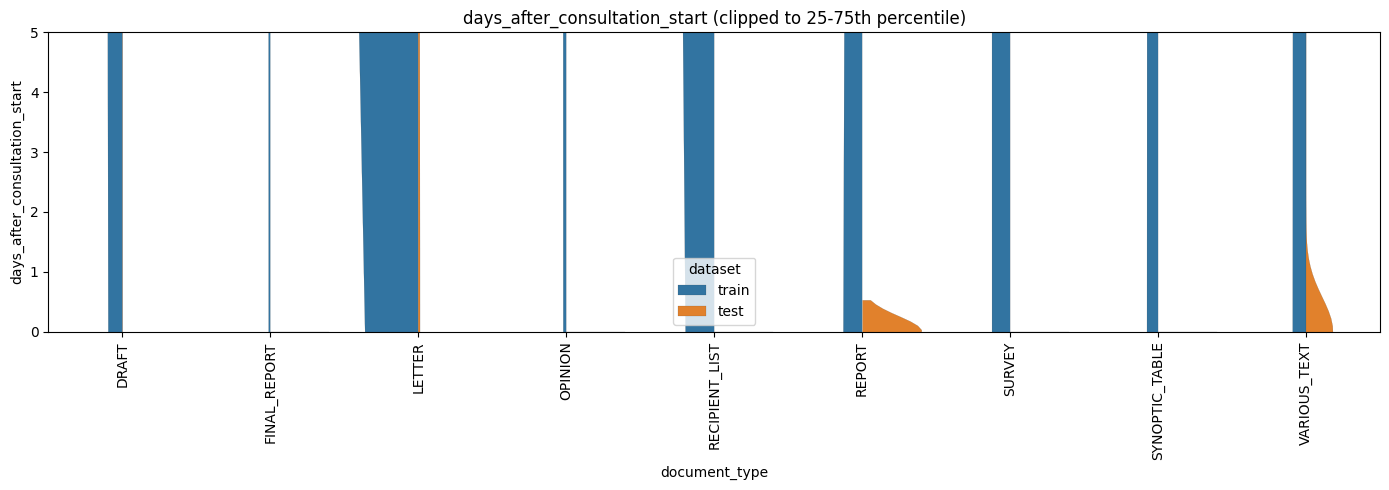

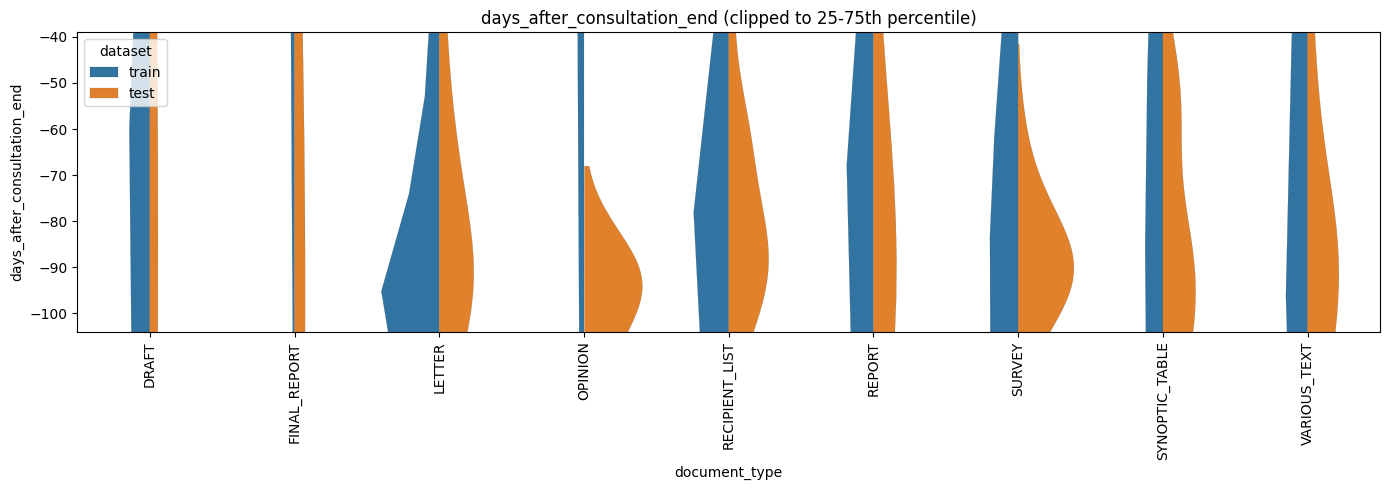

In [29]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_start",
    clip_y=(25, 75),
)
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_end",
    clip_y=(25, 75),
)

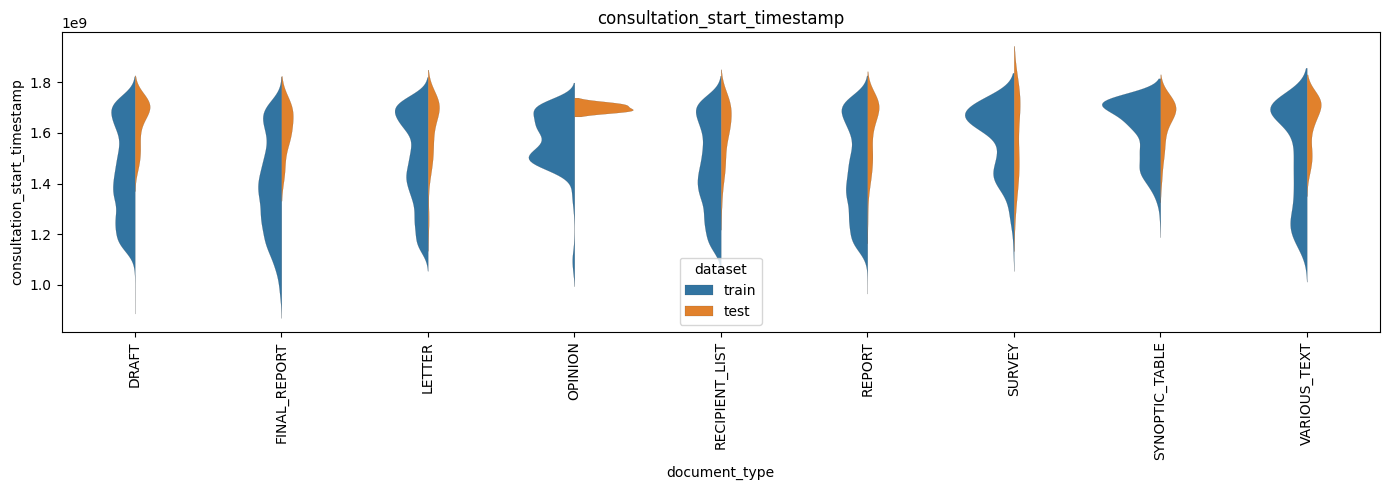

In [30]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "consultation_start_timestamp",
    # clip_y=(25, 75),
)

# Classification

In [31]:
mlflow.log_param("extra_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS))
mlflow.log_param(
    "extra_categorical_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
)

X_train, y_train = demokratis_ml.models.document_types.model.create_matrices(df_input_train, fill_nulls=True)
X_test_1, y_test_1 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_1, fill_nulls=True)
X_test_2, y_test_2 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_2, fill_nulls=True)

print("train", X_train.shape)
print("test_1", X_test_1.shape)
print("test_2", X_test_2.shape)

train (15134, 3084)
test_1 (361, 3084)
test_2 (361, 3084)


## Hyperoptimisation on test_1

In [32]:
def objective_function(params: dict[str, Any]) -> dict[str, Any]:
    logging.info("Training for hyperparameters: %s", params)
    # return {"loss": 1, "status": hyperopt.STATUS_OK}
    classifier = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        random_state=RANDOM_STATE,
        params=params,
    )
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test_1)
    f1 = sklearn.metrics.f1_score(y_test_1, y_pred, average="weighted", zero_division=np.nan)
    logging.info("F1=%.3f for %s", f1, params)
    return {"loss": -f1, "status": hyperopt.STATUS_OK, "params": params, "f1": f1}


max_evals = 2000

# See https://github.com/hyperopt/hyperopt/issues/253 about the scope.int call
quniform = lambda name, low, high, q: pyll.base.scope.int(hyperopt.hp.quniform(name, low, high, q))  # noqa: E731

search_space = {
    "pca_n_components": quniform("pca_n_components", 50, 400, 10),
    "classifier": hyperopt.hp.choice(
        "classifier",
        [
            # {
            #     "type": "LogisticRegression",
            # },
            {
                "type": "SVC",
                # "C": hyperopt.hp.lognormal("svm_C", 0, 1),
                "C": hyperopt.hp.loguniform("svm_C", np.log(1e-3), np.log(1e3)),
                "gamma": hyperopt.hp.loguniform("svm_gamma", np.log(1e-4), np.log(1e1)),
                "kernel": hyperopt.hp.choice(
                    "svm_kernel",
                    [
                        {"type": "poly", "degree": quniform("svm_poly_degree", 2, 5, 1)},
                        {"type": "rbf"},
                        {"type": "sigmoid"},
                    ],
                ),
                "class_weight": hyperopt.hp.choice("svm_class_weight", ["balanced", None]),
            },
            # We'll try tuning MLP separately
            # {
            #     "type": "MLP",
            #     "hidden_layer_sizes": hyperopt.hp.choice(
            #         "hidden_layer_sizes",
            #         [
            #             (quniform("hidden_layer_size", 64, 512, 32),),
            #             (
            #                 quniform("hidden_layer_size_0", 64, 512, 32),
            #                 quniform("hidden_layer_size_1", 64, 512, 32),
            #             ),
            #         ],
            #     ),
            # },
            # {
            #     "type": "RandomForest",
            #     "n_estimators": quniform("rf_n_estimators", 10, 200, 10),
            #     "criterion": hyperopt.hp.choice("rf_criterion", ["gini", "entropy", "log_loss"]),
            #     "max_depth": hyperopt.hp.choice("rf_max_depth_choice", [None, quniform("rf_max_depth", 5, 50, 1)]),
            #     "min_samples_split": quniform("rf_min_samples_split", 2, 20, 1),
            #     "min_samples_leaf": quniform("rf_min_samples_leaf", 1, 20, 1),
            #     "class_weight": hyperopt.hp.choice("rf_class_weight", ["balanced", None]),
            # },
        ],
    ),
}

if RUN_HYPEROPTIMIZATION:
    assert HYPERPARAMETERS is None, "HYPERPARAMETERS should be pre-defined when running hyperoptimization"
    trials = hyperopt.Trials()
    best_params = hyperopt.fmin(
        objective_function,
        search_space,
        algo=hyperopt.tpe.suggest,
        max_evals=max_evals,
        trials=trials,
    )
    display(best_params)
    assert trials.best_trial
    print(f"F1 {trials.best_trial['result']['f1']:.4f}")
    HYPERPARAMETERS = trials.best_trial["result"]["params"]
else:
    print("Using pre-defined hyperparameters")

Using pre-defined hyperparameters


In [33]:
mlflow.log_param("hyperparameters", HYPERPARAMETERS)

{'classifier': {'type': 'SVC',
  'C': 1.0,
  'class_weight': None,
  'gamma': 'scale',
  'kernel': {'type': 'rbf'}},
 'pca_n_components': 100}

## CV

In [34]:
mlflow.sklearn.autolog()

2025/06/30 12:23:23 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [35]:
classifier_cv = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=HYPERPARAMETERS,
    random_state=RANDOM_STATE,
)
classifier_cv

,steps,"[('columntransformer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
cv = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: sklearn.pipeline.Pipeline, X: Any, y: Any = None) -> np.float64:
    pca = demokratis_ml.models.document_types.model.get_pca_step(pipeline)
    if pca is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

print("cross_validate...")
cv_scores = sklearn.model_selection.cross_validate(
    classifier_cv, X=X_train, y=y_train, cv=cv, scoring=scoring, verbose=1, n_jobs=-1
)
display(cv_scores)

print("\ncross_val_predict...")
y_cv_predicted = sklearn.model_selection.cross_val_predict(
    classifier_cv, X=X_train, y=y_train, cv=cv, verbose=2, n_jobs=-1
)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_res

{'fit_time': array([12.87828565, 12.70265985, 13.10861874, 12.28807497, 12.4253099 ]),
 'score_time': array([2.52147818, 2.50997925, 2.491153  , 2.44955707, 2.55364609]),
 'test_precision': array([0.94760753, 0.95284316, 0.94842879, 0.94890544, 0.94835493]),
 'test_recall': array([0.94945491, 0.95507103, 0.94945491, 0.95077635, 0.9494382 ]),
 'test_f1': array([0.94728665, 0.95315622, 0.94743419, 0.94856753, 0.94710867]),
 'test_pca_explained_variance': array([0.65691811, 0.65766919, 0.65750265, 0.65654129, 0.65704799]),
 'test_accuracy': array([0.94945491, 0.95507103, 0.94945491, 0.95077635, 0.9494382 ]),
 'test_top_k_accuracy': array([0.98116947, 0.98645524, 0.98249092, 0.98579452, 0.98116325])}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



cross_val_predict...


/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from usi

In [37]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in cv_scores.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9508,
 'cv_f1': 0.9487,
 'cv_pca_explained_variance': 0.6571,
 'cv_precision': 0.9492,
 'cv_recall': 0.9508,
 'cv_top_k_accuracy': 0.9834}


                precision    recall  f1-score   support

         DRAFT       0.92      0.95      0.93      3057
  FINAL_REPORT       0.99      0.98      0.98      1839
        LETTER       0.99      1.00      0.99      3265
       OPINION       0.98      0.96      0.97       895
RECIPIENT_LIST       0.99      1.00      1.00      2162
        REPORT       0.91      0.97      0.94      2493
        SURVEY       0.96      0.85      0.90       197
SYNOPTIC_TABLE       0.89      0.81      0.85       579
  VARIOUS_TEXT       0.77      0.54      0.63       647

      accuracy                           0.95     15134
     macro avg       0.93      0.90      0.91     15134
  weighted avg       0.95      0.95      0.95     15134



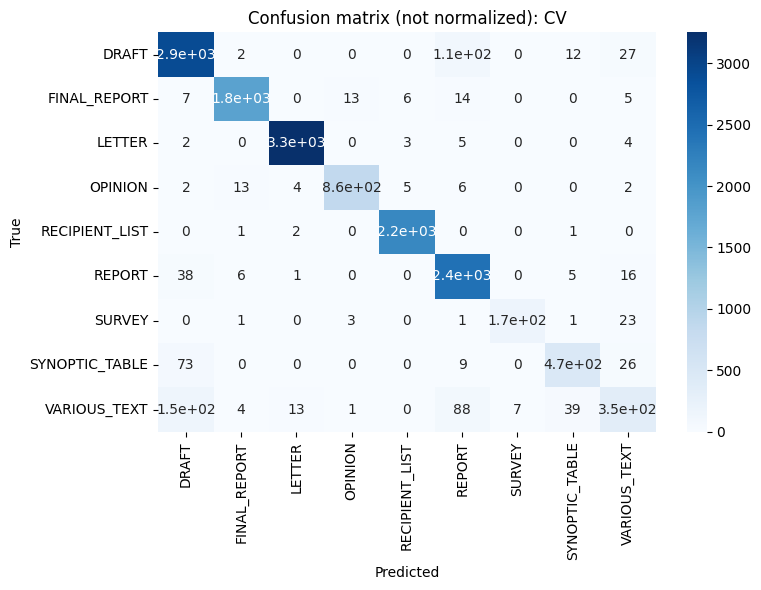

In [38]:
report = sklearn.metrics.classification_report(y_train, y_cv_predicted, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_train, y_cv_predicted, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

## Training

In [39]:
classifier_test = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=HYPERPARAMETERS,
    random_state=RANDOM_STATE,
)
classifier_test.fit(X_train, y_train)

2025/06/30 12:23:58 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/06/30 12:24:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


,steps,"[('columntransformer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluation on test_2

                precision    recall  f1-score   support

         DRAFT       0.92      0.92      0.92        50
  FINAL_REPORT       1.00      1.00      1.00        14
        LETTER       0.99      1.00      0.99        71
       OPINION       1.00      1.00      1.00         4
RECIPIENT_LIST       1.00      1.00      1.00        33
        REPORT       0.87      0.93      0.90        86
        SURVEY       1.00      1.00      1.00        10
SYNOPTIC_TABLE       0.97      0.95      0.96        41
  VARIOUS_TEXT       0.87      0.77      0.82        52

      accuracy                           0.93       361
     macro avg       0.96      0.95      0.95       361
  weighted avg       0.93      0.93      0.93       361



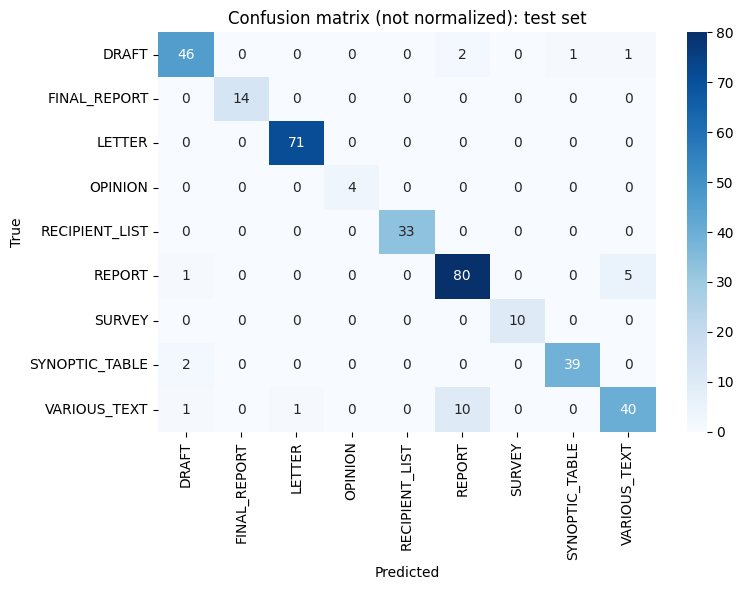

{'test_accuracy': 0.9335,
 'test_f1': 0.9328,
 'test_precision': 0.9335,
 'test_recall': 0.9335}


In [40]:
y_test_2_predicted = classifier_test.predict(X_test_2)

# Classification report
report = sklearn.metrics.classification_report(
    y_test_2,
    y_test_2_predicted,
    zero_division=np.nan,
)
mlflow.log_text(report, "test_classification_report.txt")
print(report)

# Confusion matrix
cm = plotting.plot_confusion_matrix_heatmap(y_test_2, y_test_2_predicted, title="test set")
mlflow.log_figure(cm, "test_confusion_matrix.png")
display(cm)

# Metrics
test_metrics = sklearn.metrics.precision_recall_fscore_support(
    y_test_2,
    y_test_2_predicted,
    average="weighted",
    zero_division=np.nan,
)
utils.log_metrics(
    test_precision=test_metrics[0],
    test_recall=test_metrics[1],
    test_f1=test_metrics[2],
    test_accuracy=sklearn.metrics.accuracy_score(y_test_2, y_test_2_predicted),
    # test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(y_test_2, classifier_test_2.predict_proba(X_test_2)),
)

### Feature importance

In [41]:
# forest = classifier_test.named_steps["randomforestclassifier"]
# pca = demokratis_ml.models.document_types.model.get_pca_step(classifier_test)
# assert pca is not None

# forest_importances = pd.Series(
#     forest.feature_importances_,
#     index=(
#         [f"embedding_{i:02d}" for i in range(pca.n_components)]
#         + list(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS)
#         + list(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
#     ),
# )
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# fig, ax = plt.subplots(figsize=(12, 2.5 * np.log(len(forest_importances))))
# forest_importances.plot.barh(xerr=std, ax=ax)
# ax.invert_yaxis()  # start with embeddings at the top
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

# mlflow.log_figure(fig, "feature_importance_mdi.png")

### Results per canton

In [42]:
df_eval = df_input_test_2.copy()
df_eval["document_type_predicted"] = y_test_2_predicted

for canton_code, df_canton in df_eval.groupby("political_body", observed=False):
    # Skip the "ch" political_body, which is the federal level and not a canton
    if canton_code == "ch":
        continue
    print(f"\n{'-' * 60}\n{canton_code}\n{'-' * 60}")
    if df_canton.empty:
        print("No data")
    else:
        report = sklearn.metrics.classification_report(
            df_canton["document_type"], df_canton["document_type_predicted"], zero_division=np.nan
        )
        print(report)


------------------------------------------------------------
ag
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       0.00       nan      0.00         0
        LETTER       1.00      1.00      1.00         7
RECIPIENT_LIST       1.00      1.00      1.00         5
        REPORT       0.88      1.00      0.93         7
        SURVEY       1.00      1.00      1.00         7
SYNOPTIC_TABLE       1.00      0.80      0.89         5
  VARIOUS_TEXT       1.00      0.75      0.86         4

      accuracy                           0.94        35
     macro avg       0.84      0.92      0.81        35
  weighted avg       0.97      0.94      0.95        35


------------------------------------------------------------
ai
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       1.00      1.00      1.00         7
        LETTER  

## Comparison to the rule-based model

In [43]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_input_test_2.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
y_test_predicted_rules = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df),
    demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.28% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 2.49% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.66% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.28% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
WARNING document_ti

                precision    recall  f1-score   support

         DRAFT       0.72      1.00      0.84        38
  FINAL_REPORT       1.00      0.33      0.50         3
        LETTER       0.99      1.00      0.99        69
RECIPIENT_LIST       1.00      1.00      1.00        27
        REPORT       0.95      0.85      0.90        74
        SURVEY       1.00      1.00      1.00        10
SYNOPTIC_TABLE       1.00      0.92      0.96        37
  VARIOUS_TEXT       1.00      0.88      0.93        24

      accuracy                           0.93       282
     macro avg       0.96      0.87      0.89       282
  weighted avg       0.95      0.93      0.93       282



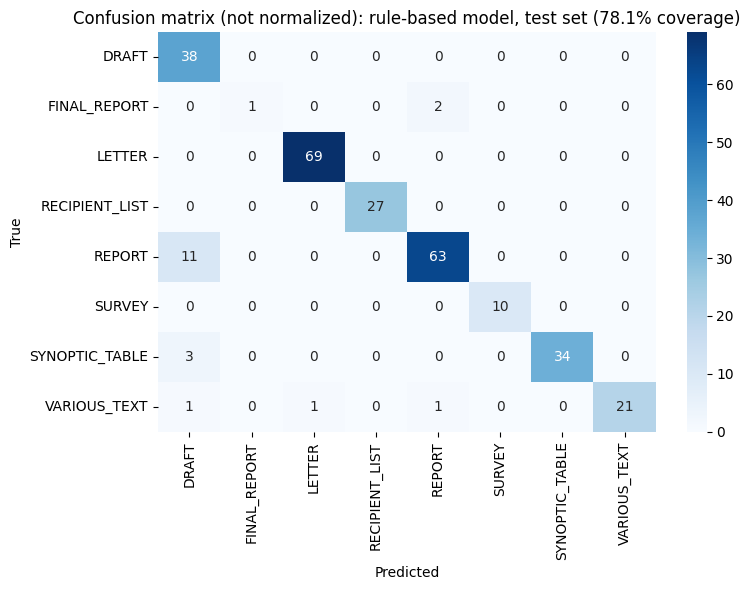

In [44]:
_y_true = y_test_2[y_test_predicted_rules.notna()]
_y_predicted = y_test_predicted_rules[y_test_predicted_rules.notna()]

coverage = np.mean(y_test_predicted_rules.notna())
print(sklearn.metrics.classification_report(_y_true, _y_predicted, zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _y_true,
    _y_predicted,
    title=f"rule-based model, test set ({100 * coverage:.1f}% coverage)",
    # normalize="true",
)

## Display all test samples & predictions

In [45]:
df_display = df_input_test_2.copy()
df_display["prediction_rule"] = y_test_predicted_rules
df_display["prediction_ml"] = y_test_2_predicted

df_display[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).apply(
    lambda row: [
        f"color: {'green' if row[col] == row['document_type'] else 'red'}"
        if col in {"prediction_rule", "prediction_ml"}
        else ""
        for col in row.index
    ],
    axis=1,
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
51926,53753,lu,vnl,doc,Einladungsschreiben und Verteiler,LETTER,LETTER,LETTER
47221,48220,zh,vnl,doc,Auszug aus dem Protokoll des RR,VARIOUS_TEXT,nan,VARIOUS_TEXT
46955,47950,zh,vnl,doc,Antrag VVO Bericht und Vorlage,REPORT,nan,REPORT
44647,45393,tg,vnl,doc,Erläuternder Bericht Jagdgesetz,REPORT,REPORT,REPORT
52855,54754,zh,vnl,doc,Synopse VSVK,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
39523,39693,ai,vnl,doc,Entwurf Wildruheverordnung (WRV),DRAFT,DRAFT,DRAFT
48036,49092,zg,vnl,doc,Liste der Adressatinnen und -adressaten,RECIPIENT_LIST,nan,RECIPIENT_LIST
49666,50832,ur,vnl,doc,Änderungserlass Revision KJSV,DRAFT,DRAFT,DRAFT
53288,55229,ai,vnl,doc,Entwurf Botschaft PeV,REPORT,DRAFT,REPORT
41624,41872,bs,vnl,doc,Ratschlagsentwurf,REPORT,REPORT,REPORT


***

# End run

In [46]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [47]:
mlflow.end_run()

🏃 View run loud-cub-101 at: https://mlflow.ml1.demokratis.ch/#/experiments/4/runs/37bff8df33604262a11408758f6a86a0
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/4
